# Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

## Project instructions

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

## Data description

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

## Preparation

In [1]:
#import libraries
import pandas as pd
import numpy as np
from pmdarima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb

In [2]:
#read in the data
# Load the data
data = pd.read_csv('/datasets/taxi.csv', parse_dates=['datetime'], index_col='datetime')

# Resample by the hour
data_hourly = data.resample('H').sum()

In [3]:
# Check for missing values
print(data_hourly.isnull().sum())

# Handle missing values (if any)
data_hourly.fillna(method='ffill', inplace=True)

num_orders    0
dtype: int64


## Analysis

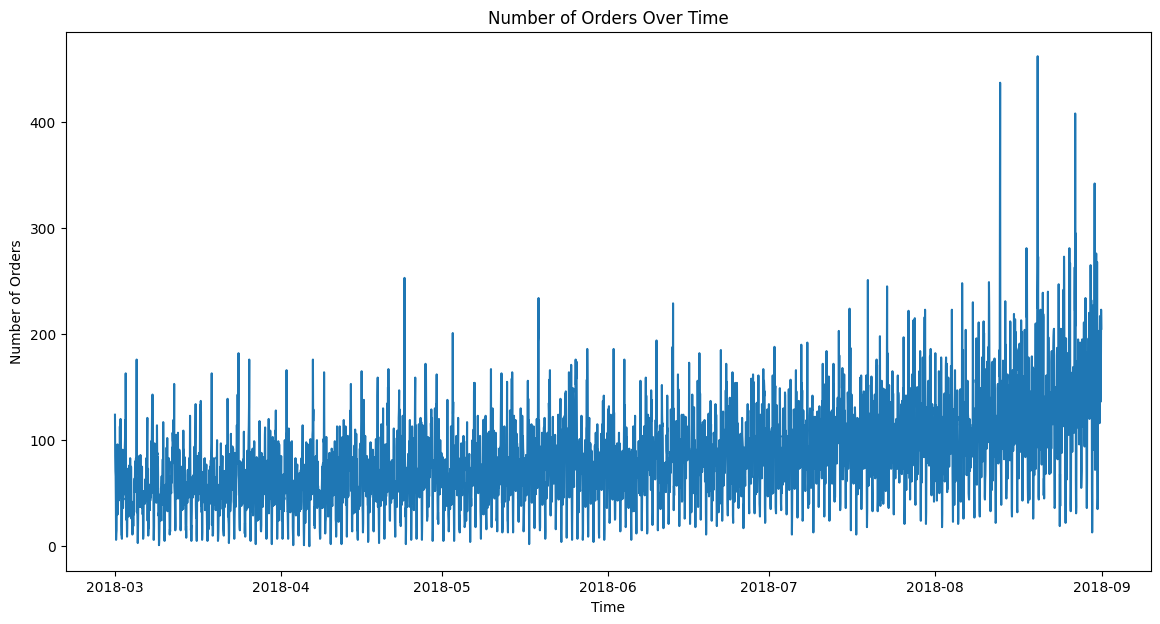

In [4]:
plt.figure(figsize=(14, 7))
plt.plot(data_hourly['num_orders'])
plt.title('Number of Orders Over Time')
plt.xlabel('Time')
plt.ylabel('Number of Orders')
plt.show()

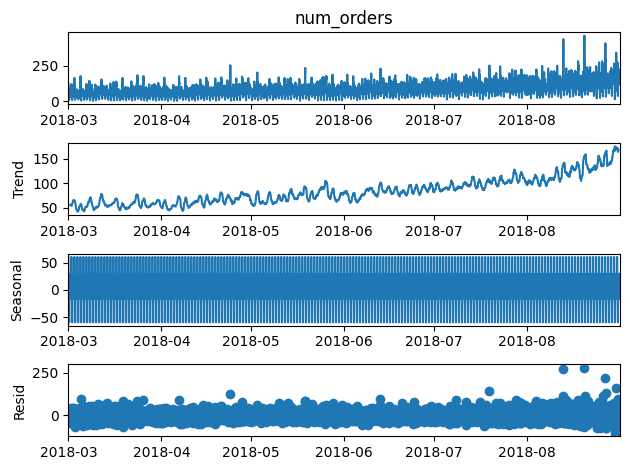

In [5]:
# Decompose the time series
decomposition = seasonal_decompose(data_hourly['num_orders'], model='additive', period=24)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot the decomposition
decomposition.plot()
plt.show()

Here we can see the number of orders clearly trends upward as the year progresses. The seasonality is much harder to visualize and will take some more analysis to determine. 

<AxesSubplot:xlabel='datetime'>

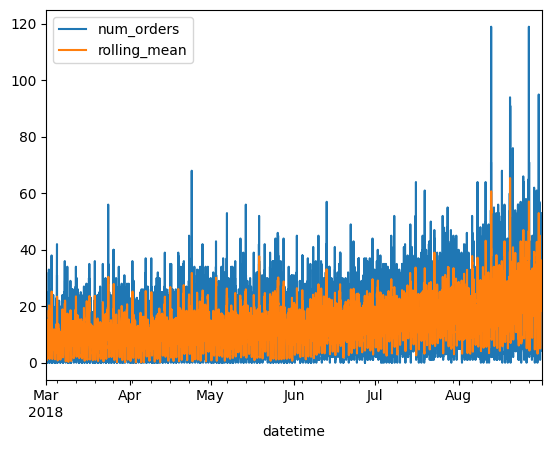

In [6]:
data_vis_1 = data.copy()
data_vis_1['rolling_mean'] = data_vis_1.rolling(10).mean()
data_vis_1.plot()

This rolling average shows a bit more clearly that the data is nonstationary. This points us toward the use of a ARIMA model or some variation of it. 

## Training

In [7]:
# Split the data into training and testing sets
train_size = int(len(data_hourly) * 0.9)
train, test = data_hourly.iloc[:train_size], data_hourly.iloc[train_size:]

In [8]:
#introduce a sanity check for future model testing
print('Median hourly rides:', test['num_orders'].median())

pred_previous = test.shift()
pred_previous.iloc[0] = train.iloc[-1]
print('RMSE:', mean_squared_error(test,pred_previous, squared=False))

Median hourly rides: 135.0
RMSE: 58.856486242815066


### Auto_arima

I was able to get auto_arima to fit the data on my local machine (after about 20min) with the following parameters. I will create the trained model on the parameters shown in the summary in the following cell.

In [9]:
#seasonal_period = 24

# Fit the auto_arima model
#model = auto_arima(train['num_orders'], seasonal=True, m=seasonal_period,
                   #stepwise=True, suppress_warnings=True, scoring='mse')

# Make predictions
#predictions = model.predict(n_periods=len(test))

# Create a new column to store predictions
#data_hourly['predicted_orders'] = [np.nan] * len(data_hourly)
#data_hourly.iloc[train_size:, -1] = predictions

# Rename original column
#data_hourly.rename(columns={'num_orders': 'actual_orders'}, inplace=True)

# Print the dataframe
#print(data_hourly)

In [10]:
#fitting the parameters from the auto_arima

best_params = {'maxiter': 50, 'method': 'lbfgs', 'order': (5, 1, 0), 
 'out_of_sample_size': 0, 'scoring': 'mse', 'scoring_args': {}, 
 'seasonal_order': (1, 0, 0, 24), 'start_params': None, 
 'suppress_warnings': True, 'trend': None, 'with_intercept': False}

# Extract the parameters
order = (best_params['order'][0], best_params['order'][1], best_params['order'][2])
seasonal_order = (best_params['seasonal_order'][0], best_params['seasonal_order'][1], best_params['seasonal_order'][2], best_params['seasonal_order'][3])

p, d, q = best_params['order']
P, D, Q, m = best_params['seasonal_order']

# Fit the SARIMAX model using these parameters
sarimax_model = SARIMAX(train['num_orders'], order=order, seasonal_order=seasonal_order)
sarimax_fit = sarimax_model.fit(disp=False)

print(sarimax_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                         num_orders   No. Observations:                 3974
Model:             SARIMAX(5, 1, 0)x(1, 0, 0, 24)   Log Likelihood              -18908.217
Date:                            Sat, 13 Jul 2024   AIC                          37830.434
Time:                                    21:15:43   BIC                          37874.445
Sample:                                03-01-2018   HQIC                         37846.040
                                     - 08-13-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6335      0.012    -51.440      0.000      -0.658      -0.609
ar.L2         -0.4241      0.015   

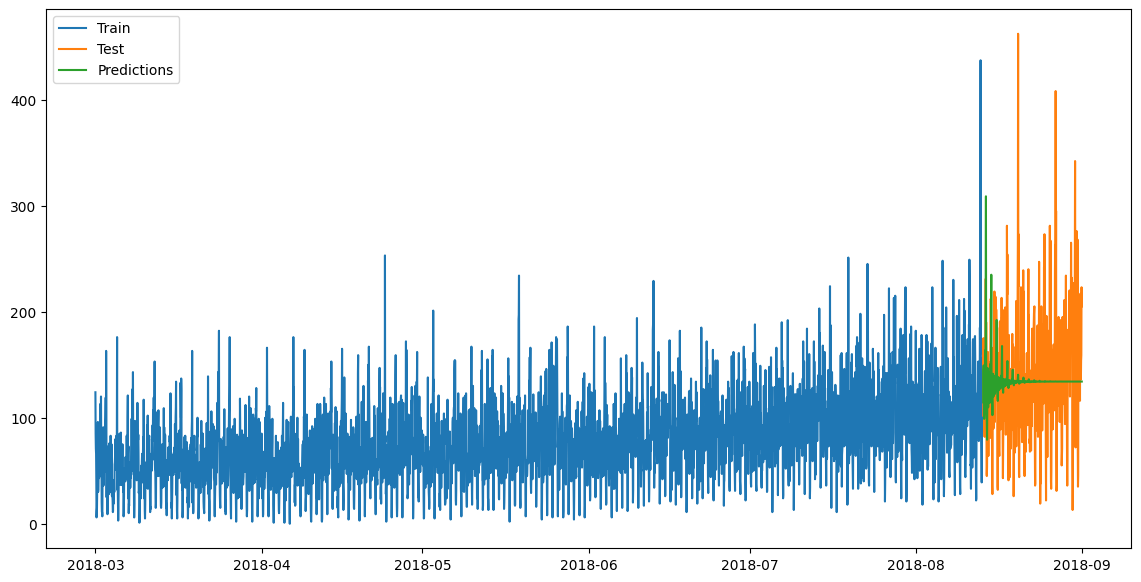

In [11]:
# Make predictions
predictions = sarimax_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

# Plot the predictions along with actual values
plt.figure(figsize=(14, 7))
plt.plot(train['num_orders'], label='Train')
plt.plot(test['num_orders'], label='Test')
plt.plot(predictions, label='Predictions')
plt.legend(loc='best')
plt.show()

The training of this model shows that the predictions are not useful with the current parameters. We will now explore residuals in order to find some seasonality to better train the model. 

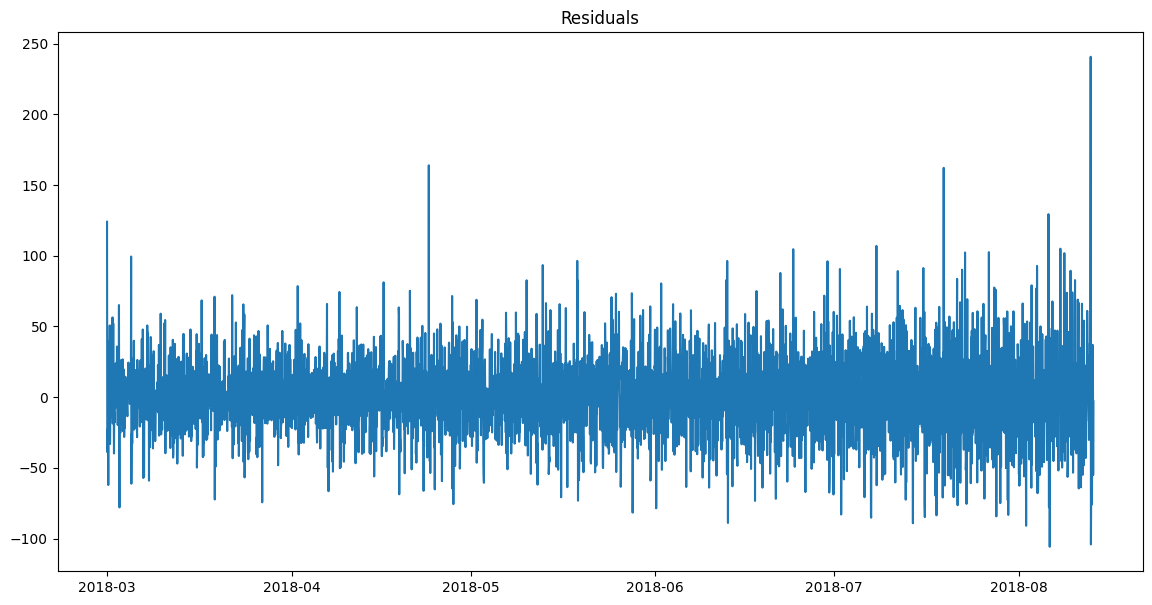

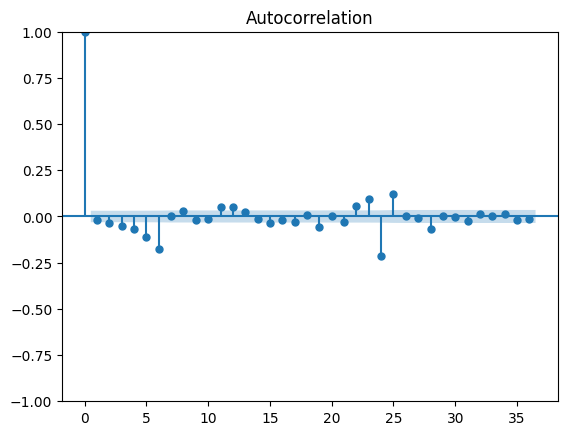

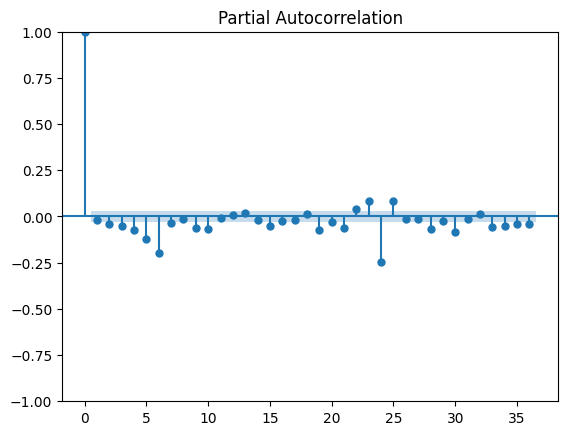

In [12]:
residuals = sarimax_fit.resid
plt.figure(figsize=(14, 7))
plt.plot(residuals)
plt.title('Residuals')
plt.show()

sm.graphics.tsa.plot_acf(residuals)
sm.graphics.tsa.plot_pacf(residuals)
plt.show()

Here we can see the ACF and PACF plots indicate cycles at 6 and 24 hours. Perhaps adding lags at these intervals will be useful in better training the model parameters. 

In [13]:
# Adding lag features
data_hourly['lag_6'] = data_hourly['num_orders'].shift(6)
data_hourly['lag_24'] = data_hourly['num_orders'].shift(24)
data_hourly.dropna(inplace=True)

# Re-split the data
train_size = int(len(data_hourly) * 0.9)
train, test = data_hourly.iloc[:train_size], data_hourly.iloc[train_size:]

X_train, y_train = train.drop(columns=['num_orders']), train['num_orders']
X_test, y_test = test.drop(columns=['num_orders']), test['num_orders']

# Fit the SARIMAX model using the lagged features as exogenous variables
sarimax_model = SARIMAX(y_train, 
                        exog=X_train[['lag_6', 'lag_24']], 
                        order=(p, d, q), 
                        seasonal_order=(P, D, Q, m))
sarimax_fit = sarimax_model.fit(disp=False)

print(sarimax_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                         num_orders   No. Observations:                 3952
Model:             SARIMAX(5, 1, 0)x(1, 0, 0, 24)   Log Likelihood              -18431.758
Date:                            Sat, 13 Jul 2024   AIC                          36881.516
Time:                                    21:16:42   BIC                          36938.052
Sample:                                03-02-2018   HQIC                         36901.569
                                     - 08-13-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
lag_6         -0.0886      0.010     -8.941      0.000      -0.108      -0.069
lag_24         0.8156      0.009   

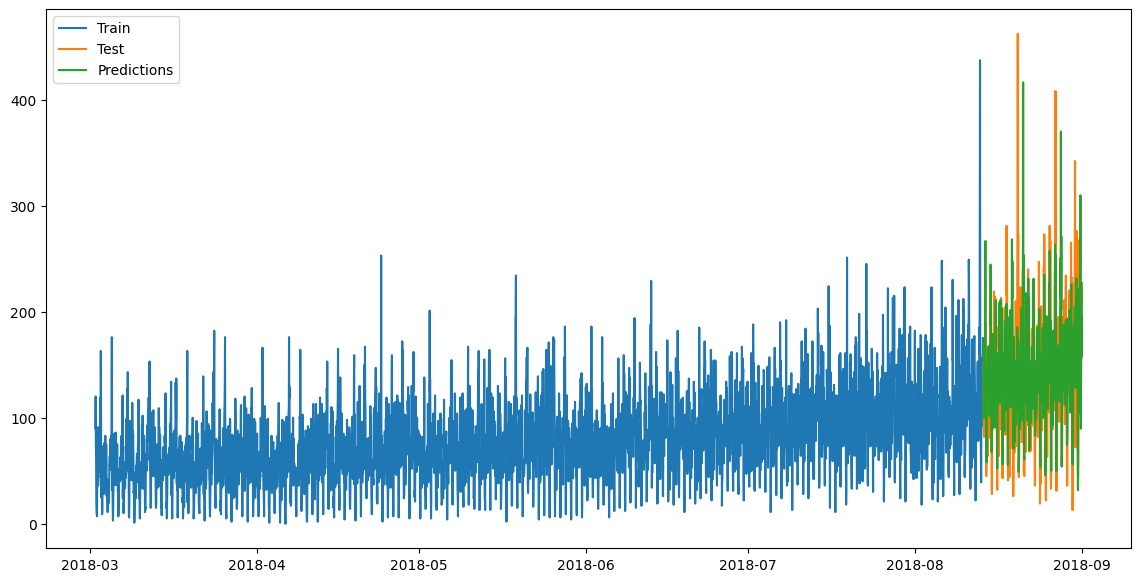

SARIMAX RMSE: 52.686879230916844


In [14]:
# Make predictions with exogenous variables
predictions = sarimax_fit.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, exog=X_test[['lag_6', 'lag_24']])

plt.figure(figsize=(14, 7))
plt.plot(y_train, label='Train')
plt.plot(y_test, label='Test')
plt.plot(predictions, label='Predictions')
plt.legend(loc='best')
plt.show()

rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f'SARIMAX RMSE: {rmse}')

The addition of the lag features greatly improved the RMSE score from 57 to 52. Let's explore what other models might be appropriate for this dataset. 

<Figure size 1400x700 with 0 Axes>

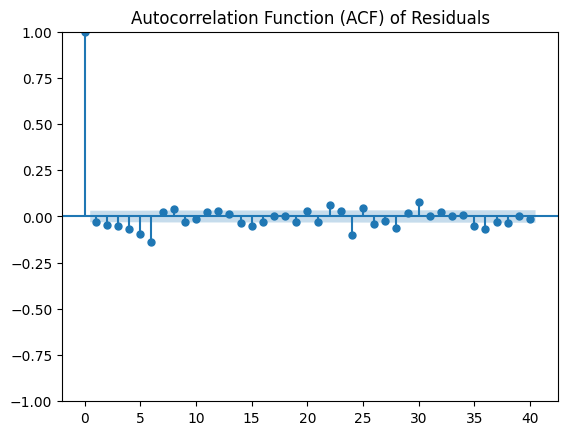

<Figure size 1400x700 with 0 Axes>

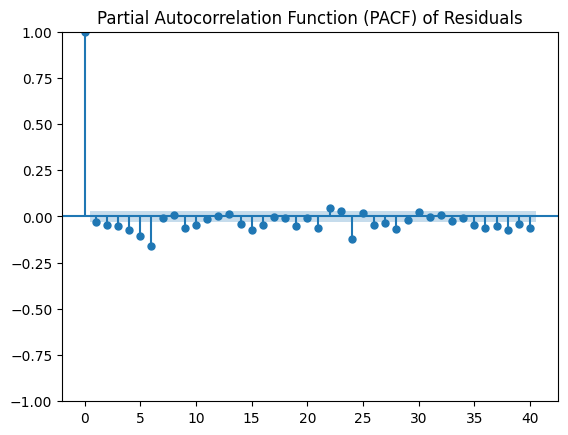

In [15]:
#reviewing the residuals after adding the lag feaures
residuals = sarimax_fit.resid
plt.figure(figsize=(14, 7))
sm.graphics.tsa.plot_acf(residuals, lags=40)
plt.title('Autocorrelation Function (ACF) of Residuals')
plt.show()

plt.figure(figsize=(14, 7))
sm.graphics.tsa.plot_pacf(residuals, lags=40)
plt.title('Partial Autocorrelation Function (PACF) of Residuals')
plt.show()

The same residuals exist after the lag features were added, but tuning the model any more did not have positive results with further testing. It's time to move onto other models to see what else is available, especially consdering the very long training time the pdarima method took. 

The simplicity of the Holt-Winters model likely improved on the previous models due to it's lack of overfitted parameters. 

### Holt-Winters Seasonal Model

Holt-Winters RMSE: 41.188365151957704


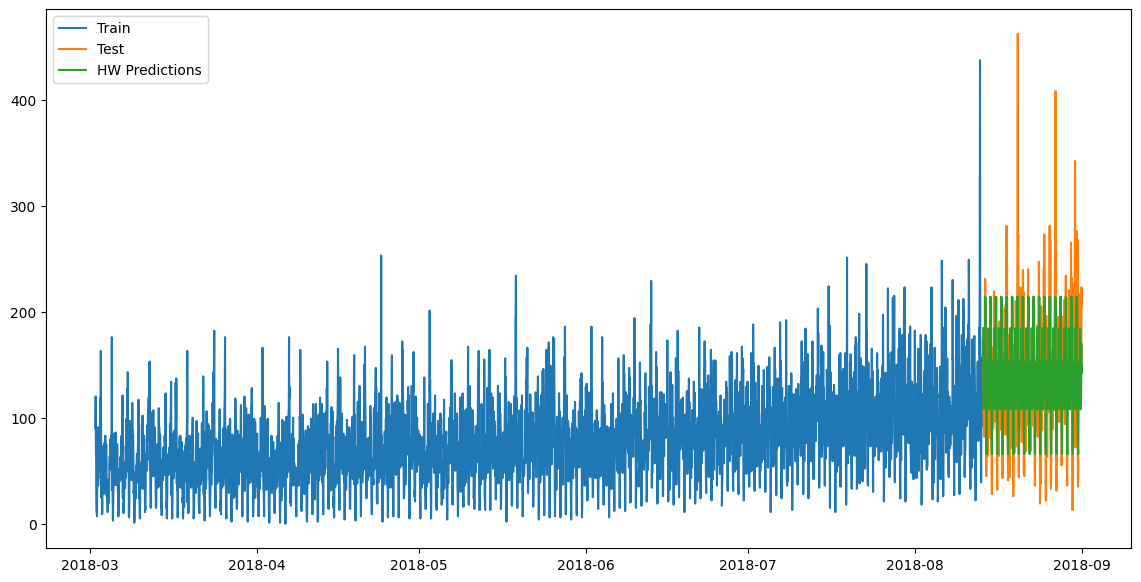

In [16]:
# Fit the Holt-Winters model
holt_winters_model = ExponentialSmoothing(y_train, seasonal='add', seasonal_periods=24).fit()

# Make predictions
predictions_hw = holt_winters_model.forecast(len(y_test))

# Calculate RMSE
rmse_hw = np.sqrt(mean_squared_error(y_test, predictions_hw))
print(f'Holt-Winters RMSE: {rmse_hw}')

# Plot the predictions along with actual values
plt.figure(figsize=(14, 7))
plt.plot(y_train, label='Train')
plt.plot(y_test, label='Test')
plt.plot(predictions_hw, label='HW Predictions')
plt.legend(loc='best')
plt.show()

The best result so far has been the Holt-Winters Seasonal model. This model, also known as Triple Exponential Smoothing, is well suited for time series data with clear seasonality and trend data. With an RMSE score of 41.18, it really improved on the results of the baseline model and highly intensive SARIMAX method. 

### XGBoost with Lag Features

In [17]:
# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [18]:
# Define a wider parameter space for random search

tscv = TimeSeriesSplit()

param_dist = {
       'n_estimators': [50, 100, 200],
       'max_depth': [3, 5, 7],
       'learning_rate': [0.01, 0.1, 0.2],
       'subsample': [0.7, 0.8, 1.0],
       'colsample_bytree': [0.7, 0.8, 1.0],
       'reg_alpha': [0, 0.1, 0.5],
       'reg_lambda': [1, 1.5, 2]
   }

# Initialize the model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist, 
                                   n_iter=20, cv=tscv, scoring='neg_mean_squared_error', 
                                   verbose=1, n_jobs=-1, random_state=42)

# Fit RandomizedSearchCV to the data
random_search.fit(X_train_scaled, y_train)

# Best params and RMSE
best_params = random_search.best_params_
best_rmse = np.sqrt(-random_search.best_score_)
print(f'Best Params: {best_params}')
print(f'Best RMSE from Randomized Search: {best_rmse}')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Params: {'subsample': 1.0, 'reg_lambda': 1.5, 'reg_alpha': 0.5, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.2, 'colsample_bytree': 0.8}
Best RMSE from Randomized Search: 30.786911135007426


In [19]:
# Fit the final model with the best parameters
xgb_model = xgb.XGBRegressor(**best_params)
xgb_fit = xgb_model.fit(X_train_scaled, y_train)

# Make predictions
predictions_xgb = xgb_model.predict(X_test_scaled)

# Calculate RMSE
final_rmse_xgb = np.sqrt(mean_squared_error(y_test, predictions_xgb))
print(f'XGBoost RMSE with tuning: {final_rmse_xgb}')

XGBoost RMSE with tuning: 56.77648162320881


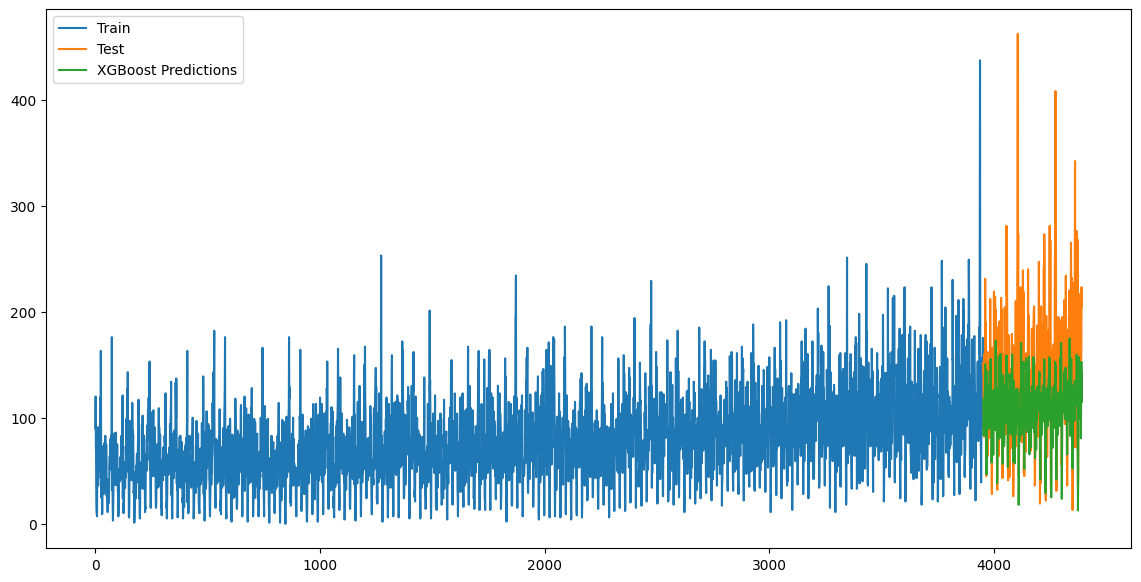

In [20]:
# Plot the predictions along with actual values
plt.figure(figsize=(14, 7))
plt.plot(y_train.values, label='Train')
plt.plot(range(len(y_train), len(y_train) + len(y_test)), y_test.values, label='Test')
plt.plot(range(len(y_train), len(y_train) + len(y_test)), predictions_xgb, label='XGBoost Predictions')
plt.legend(loc='best')
plt.show()

The RMSE of the training set with the randomized search was very low relative to the other models tested at 29.82. When fitted on the test set however, the model showed overfitting or possible data leakage, causing the RMSE to go back into the range of the baseline approach at 56.94. 

## Conclusions

The further tuning of parameters on more complex models did little to improve the model accuracy and lower the RMSE scores. The results of the best performing model within this project show that sometimes simplicity is a better approach to handling time series trends and seasonality. 

The Holt-Winters model proved to be the most accurate and fastest to train/fit. Though more paramter fitting would likely increase the performance of the other models tested, the strengths of the Holt-Winters model are apparent from the relative time spent between the different approaches. 